In [2]:
# dose_curves.py
# Requirements: numpy pandas matplotlib scipy
# Tip for headless runs: uncomment the next 2 lines
# import matplotlib
# matplotlib.use("Agg")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# --------------------------- utils ---------------------------

def sem(a, axis=0):
    a = np.asarray(a, dtype=float)
    n = np.sum(~np.isnan(a), axis=axis)
    return np.nanstd(a, axis=axis, ddof=0) / np.sqrt(np.maximum(n, 1))


def four_pl(x, top, bottom, ec50, hill):
    # 4-parameter logistic (increasing)
    # y = bottom + (top-bottom)/(1+(EC50/x)^hill)
    x = np.asarray(x, dtype=float)
    return bottom + (top - bottom) / (1.0 + (ec50 / x) ** hill)


def dose_response_fit(dose, resp):
    """
    Fit 4PL to (dose, resp). Returns:
    hill, ec50, minDose, maxDose, coeffs(dict), meanResponse, doses, model_fn
    """
    dose = np.asarray(dose, dtype=float)
    resp = np.asarray(resp, dtype=float)

    # sanitize
    msk = (~np.isnan(dose)) & (~np.isnan(resp)) & (dose > 0)
    dose, resp = dose[msk], resp[msk]
    if dose.size < 4:
        raise RuntimeError("Not enough points to fit.")

    minDose, maxDose = np.min(dose), np.max(dose)

    # initial guesses
    y0, y1 = np.nanmin(resp), np.nanmax(resp)
    p0 = [y1 if np.isfinite(y1) else 2.0,
          y0 if np.isfinite(y0) else 1.0,
          np.sqrt(minDose * maxDose),
          1.0]

    bounds = (
        [0.0, 0.0, minDose / 100.0, 0.01],          # lower
        [np.inf, np.inf, maxDose * 100.0, 10.0],    # upper
    )

    try:
        popt, _ = curve_fit(four_pl, dose, resp, p0=p0, bounds=bounds, maxfev=10000)
        top, bottom, ec50, hill = popt
    except Exception as e:
        # Fallback: simple mid-dose EC50, hill=1
        ec50 = np.sqrt(minDose * maxDose)
        hill = 1.0
        top, bottom = np.nanmax(resp), np.nanmin(resp)

    coeffs = dict(top=top, bottom=bottom, ec50=ec50, hill=hill)
    model_fn = lambda x: four_pl(x, **coeffs)
    return hill, ec50, minDose, maxDose, coeffs, np.nanmean(resp), dose, model_fn
def Normalize(curve):
    return (curve - np.min(curve))/(np.max(curve) - np.min(curve))


In [3]:
# --------------------------- main ---------------------------
# CONFIG
directory = "/mnt/hcleroy/PostDoc2/octopus_smelling/experimental_data"
xlsx = "doseHeteromer_dataAll.xlsx"
sheets = {"CR518": "CR518", "CR518_918": "CR518-918", "CR918": "CR918", "GCaMP": "GCaMP"}
ligandList = [
    "Medroxyprogesterone", "Androsterone", "Progesterone", "Estrone", "Chloroquine",
    "Strychnine", "Naringin", "Nootkatone", "Costunolide", "Taurocholic acid", "Norharmane"
]
maxDose_CR518     = np.array([9,11,11,11,11,10,11, 9, 8,11,11], dtype=int)
maxDose_CR518_918 = np.array([9,11,11,11,11,10,11,11,11,10,11], dtype=int)
maxDose_CR918     = np.array([9,11,11,11,11,10,11,11,11,10,11], dtype=int)
respThresh = 3.0

# IO
df_518     = pd.read_excel(f"{directory}/{xlsx}", sheet_name=sheets["CR518"], engine="openpyxl")
df_518_918 = pd.read_excel(f"{directory}/{xlsx}", sheet_name=sheets["CR518_918"], engine="openpyxl")
df_918     = pd.read_excel(f"{directory}/{xlsx}", sheet_name=sheets["CR918"], engine="openpyxl")
df_gc      = pd.read_excel(f"{directory}/{xlsx}", sheet_name=sheets["GCaMP"], engine="openpyxl")



In [4]:
df_518

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,NaN,NaN,DOSE,2.025061e+07,2.025061e+07,2.025062e+07,2.025062e+07,2.025062e+07,2.025062e+07,2.025062e+07,...,2.025062e+07,2.025062e+07,2.025101e+07,2.025101e+07,2.025101e+07,2.025101e+07,2.025101e+07,2.025101e+07,2.025101e+07,2.025101e+07
1,NaN,Medroxyprogesterone_raw,0.05,2.120000e+02,1.524286e+02,2.368571e+02,3.218571e+02,1.562857e+02,2.280000e+02,2.191429e+02,...,2.270000e+02,2.218571e+02,8.717143e+02,1.176714e+03,1.286714e+03,8.492857e+02,1.367000e+03,1.358286e+03,2.136857e+03,1.159000e+03
2,NaN,Medroxyprogesterone_raw,0.1,2.075714e+02,2.488571e+02,1.847143e+02,2.720000e+02,2.627143e+02,3.157143e+02,2.771429e+02,...,2.911429e+02,2.201429e+02,8.824286e+02,1.099857e+03,9.542857e+02,1.428286e+03,1.608714e+03,1.829000e+03,1.646571e+03,2.786286e+03
3,NaN,Medroxyprogesterone_raw,0.3,2.161429e+02,2.694286e+02,2.467143e+02,3.461429e+02,3.504286e+02,2.165714e+02,2.372857e+02,...,3.775714e+02,2.601429e+02,7.930000e+02,1.630143e+03,1.867286e+03,2.517857e+03,2.048286e+03,1.318000e+03,1.399429e+03,2.756000e+03
4,NaN,Medroxyprogesterone_raw,1,4.844286e+02,5.890000e+02,2.935714e+02,2.634286e+02,2.744286e+02,3.382857e+02,2.650000e+02,...,4.257143e+02,5.808571e+02,1.616429e+03,2.325143e+03,3.136714e+03,2.802714e+03,2.805143e+03,3.376857e+03,3.640571e+03,4.344429e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,NaN,Norharmane,300,4.274284e+00,8.275090e+00,8.079804e+00,3.943994e+00,3.819489e+00,3.127400e+00,2.638382e+00,...,1.783079e+01,4.434798e+00,8.411340e+00,8.355357e+00,4.084570e+00,6.444744e+00,5.063040e+00,7.623271e+00,NaN,NaN
324,NaN,Norharmane,500,4.588232e+00,8.333835e+00,7.799698e+00,3.603200e+00,2.616694e+00,3.051189e+00,2.700896e+00,...,1.663581e+01,4.454209e+00,9.758009e+00,9.324794e+00,3.925108e+00,6.142545e+00,4.629971e+00,6.615196e+00,NaN,NaN
325,NaN,Norharmane,700,4.911083e+00,7.399432e+00,7.462212e+00,3.244396e+00,2.574399e+00,2.867354e+00,2.480875e+00,...,2.004454e+01,4.817752e+00,9.536507e+00,9.230975e+00,3.744227e+00,6.095413e+00,4.835007e+00,6.156309e+00,NaN,NaN
326,NaN,Norharmane,1000,4.032316e+00,6.930141e+00,7.080030e+00,3.106020e+00,2.862599e+00,3.012571e+00,2.422236e+00,...,1.722830e+01,3.949956e+00,1.014409e+01,8.562019e+00,4.102715e+00,6.954131e+00,4.064830e+00,7.112913e+00,NaN,NaN


In [5]:
# Expect Var2 = ligand name, Var3 = dose, Var4.. = replicate responses
# Build indices for each ligand
def idx_list(df):
    out = []
    col_lig = "Var2" if "Var2" in df.columns else df.columns[1]
    for lig in ligandList:
        idx = df.index[df[col_lig] == lig].to_numpy()
        out.append(idx)
    return out

idx_518     = idx_list(df_518)
idx_518_918 = idx_list(df_518_918)
idx_918     = idx_list(df_918)
idx_gc      = idx_list(df_gc)

# Collect replicate matrices per ligand (rows: doses; cols: cells/replicates)
def grab_vals(df, idxs):
    # columns 4:end in MATLAB -> pandas iloc[:, 3:]
    return [df.iloc[idx, 3:].to_numpy(dtype=float) for idx in idxs]

CR518_all     = grab_vals(df_518, idx_518)
CR518_918_all = grab_vals(df_518_918, idx_518_918)
CR918_all     = grab_vals(df_918, idx_918)
GCaMP_all     = grab_vals(df_gc, idx_gc)


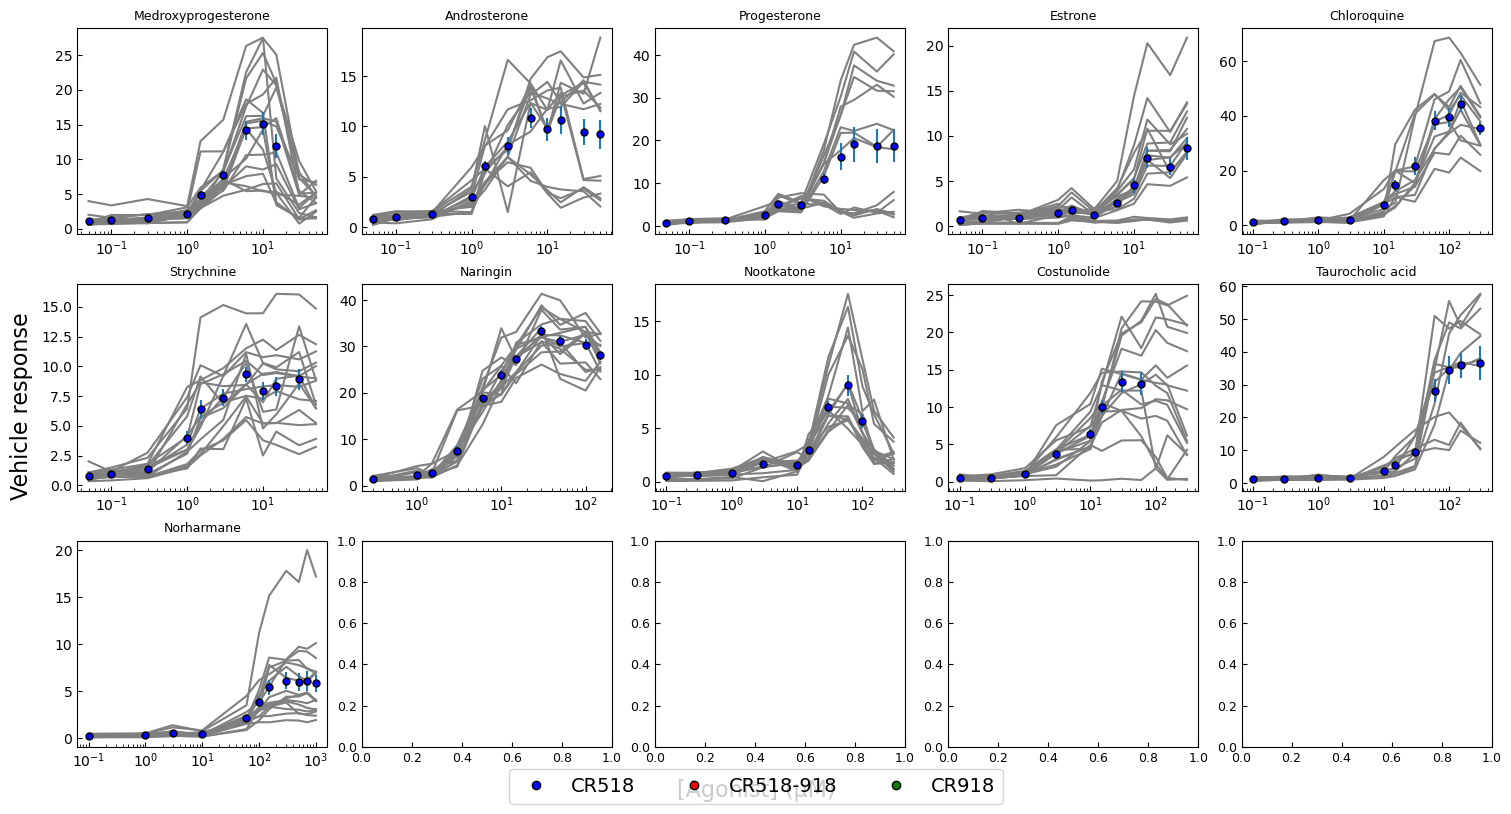

In [6]:
# ---------- plotting grid ----------
nLig = len(ligandList)
nrows, ncols = 3, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8), constrained_layout=True)
axes = axes.ravel()

for i, lig in enumerate(ligandList):
    ax = axes[i]
    # Mean curve
    mu_518     = np.nanmean(CR518_all[i], axis=1)
    # Error bars
    se_518     = sem((CR518_all[i]), axis=1)
    # Doses (Var3)
    dose_518     = df_518.iloc[idx_518[i], 2].to_numpy(dtype=float)

    for CR518 in CR518_all[i].T:
        ax.plot(dose_518[:-1],(CR518[:-1]),color='grey')
        
    k = maxDose_CR518[i]
    ax.errorbar(dose_518[:k], (mu_518[:k]), yerr=se_518[:k], fmt='o', ms=5, mfc='b', mec='k', ls='none')

    ax.set_xscale("log")
    ax.set_title(lig, fontsize=9)
    ax.tick_params(labelsize=10)
    #ax.box(False)

# shared labels
fig.supxlabel("[Agonist] (µM)", fontsize=16)
fig.supylabel("Vehicle response", fontsize=16)

# Legend (dummy handles)
h1 = axes[0].plot([], [], 'o', mfc='b', mec='k', label='CR518')[0]
h2 = axes[0].plot([], [], 'o', mfc='r', mec='k', label='CR518-918')[0]
h3 = axes[0].plot([], [], 'o', mfc='g', mec='k', label='CR918')[0]
lgd = fig.legend(handles=[h1, h2, h3], loc="lower center", ncol=3, fontsize=14, bbox_to_anchor=(0.5, -0.01))


plt.show()


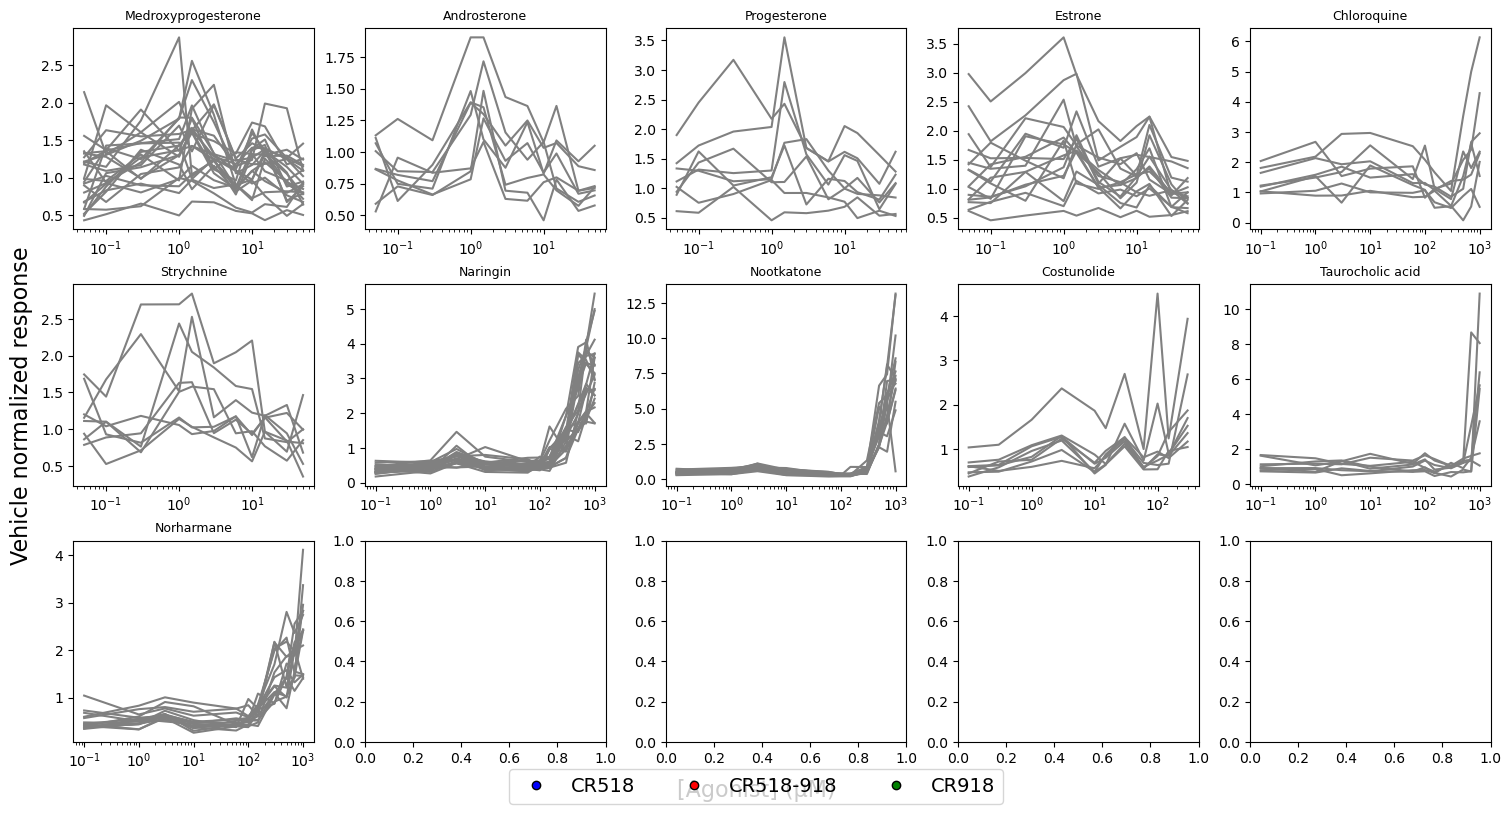

In [7]:
# ---------- plotting grid ----------
nLig = len(ligandList)
nrows, ncols = 3, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8), constrained_layout=True)
axes = axes.ravel()

for i, lig in enumerate(ligandList):
    ax = axes[i]

    # Means and SEMs (over columns)
    mu_918     = np.nanmean(CR918_all[i], axis=1)

    # Doses (Var3)
    dose_918     = df_918.iloc[idx_918[i], 2].to_numpy(dtype=float)

    for CR918 in CR918_all[i].T:
        ax.plot(dose_918[:-1],(CR918[:-1]),color='grey')


    ax.set_xscale("log")
    ax.set_title(lig, fontsize=9)
    ax.tick_params(labelsize=10)
    #ax.box(False)

# shared labels
fig.supxlabel("[Agonist] (µM)", fontsize=16)
fig.supylabel("Vehicle normalized response", fontsize=16)

# Legend (dummy handles)
h1 = axes[0].plot([], [], 'o', mfc='b', mec='k', label='CR518')[0]
h2 = axes[0].plot([], [], 'o', mfc='r', mec='k', label='CR518-918')[0]
h3 = axes[0].plot([], [], 'o', mfc='g', mec='k', label='CR918')[0]
lgd = fig.legend(handles=[h1, h2, h3], loc="lower center", ncol=3, fontsize=14, bbox_to_anchor=(0.5, -0.01))


plt.show()


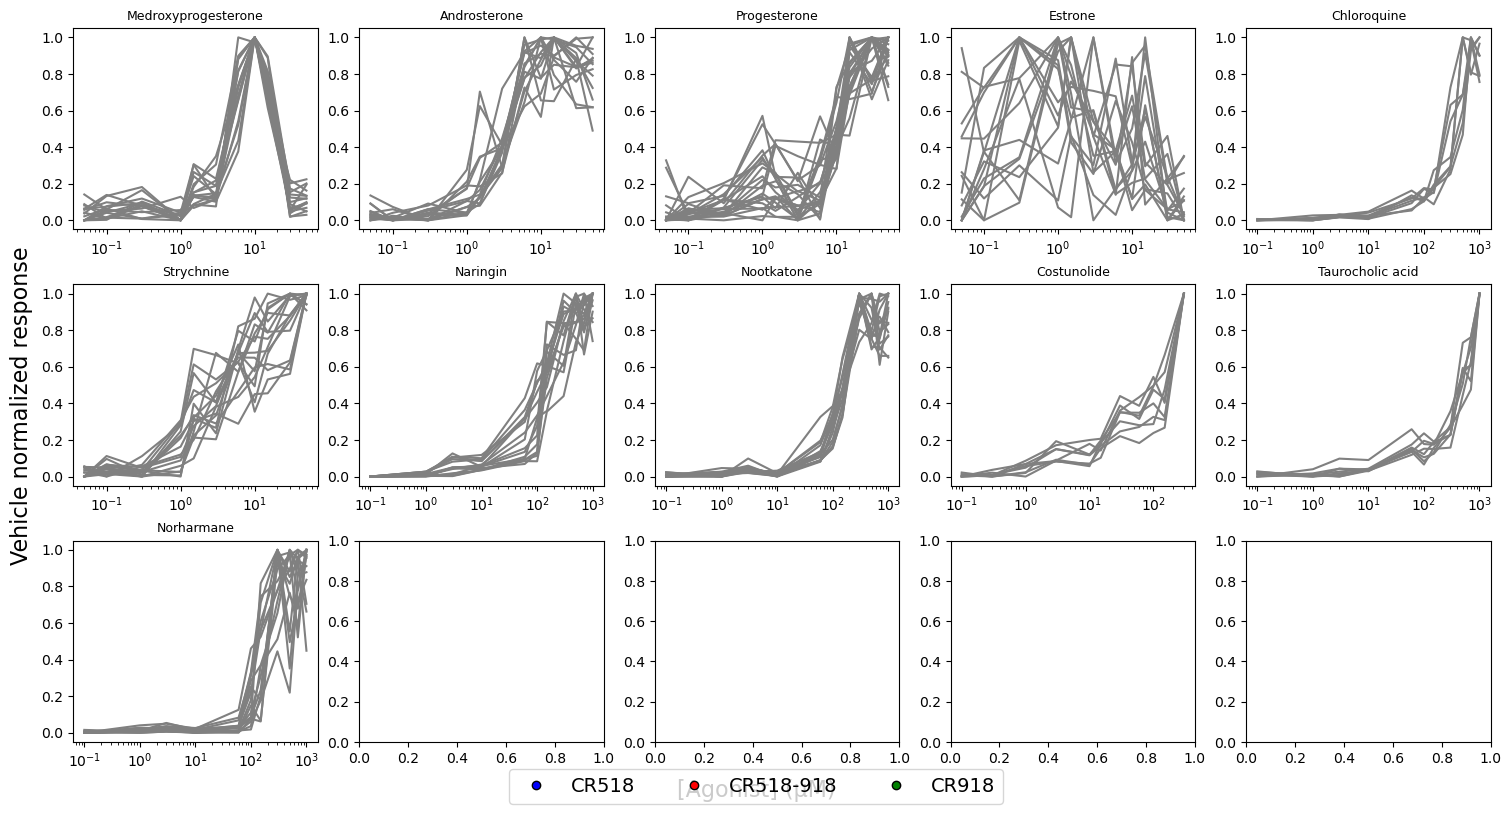

In [8]:
# ---------- plotting grid ----------
nLig = len(ligandList)
nrows, ncols = 3, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8), constrained_layout=True)
axes = axes.ravel()

for i, lig in enumerate(ligandList):
    ax = axes[i]

    # Means and SEMs (over columns)
    mu_518_918 = np.nanmean(CR518_918_all[i], axis=1)
    mu_918     = np.nanmean(CR918_all[i], axis=1)

    # Doses (Var3)
    dose_518_918 = df_518_918.iloc[idx_518_918[i], 2].to_numpy(dtype=float)

    for CR518_918 in CR518_918_all[i].T:
        ax.plot(dose_518_918[:-1],Normalize(CR518_918[:-1]),color='grey')


    ax.set_xscale("log")
    ax.set_title(lig, fontsize=9)
    ax.tick_params(labelsize=10)
    #ax.box(False)

# shared labels
fig.supxlabel("[Agonist] (µM)", fontsize=16)
fig.supylabel("Vehicle normalized response", fontsize=16)

# Legend (dummy handles)
h1 = axes[0].plot([], [], 'o', mfc='b', mec='k', label='CR518')[0]
h2 = axes[0].plot([], [], 'o', mfc='r', mec='k', label='CR518-918')[0]
h3 = axes[0].plot([], [], 'o', mfc='g', mec='k', label='CR918')[0]
lgd = fig.legend(handles=[h1, h2, h3], loc="lower center", ncol=3, fontsize=14, bbox_to_anchor=(0.5, -0.01))


plt.show()


/mnt/hcleroy/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2644/2791101468.py:64: RuntimeWarning: All-NaN slice encountered
  yMax_margin = 5 if np.isnan(np.nanmax(se_518)) else np.nanmax(se_518)
/tmp/ipykernel_2644/2791101468.py:16: RuntimeWarning: Mean of empty slice
  mu_gc      = np.nanmean(GCaMP_all[i], axis=1)


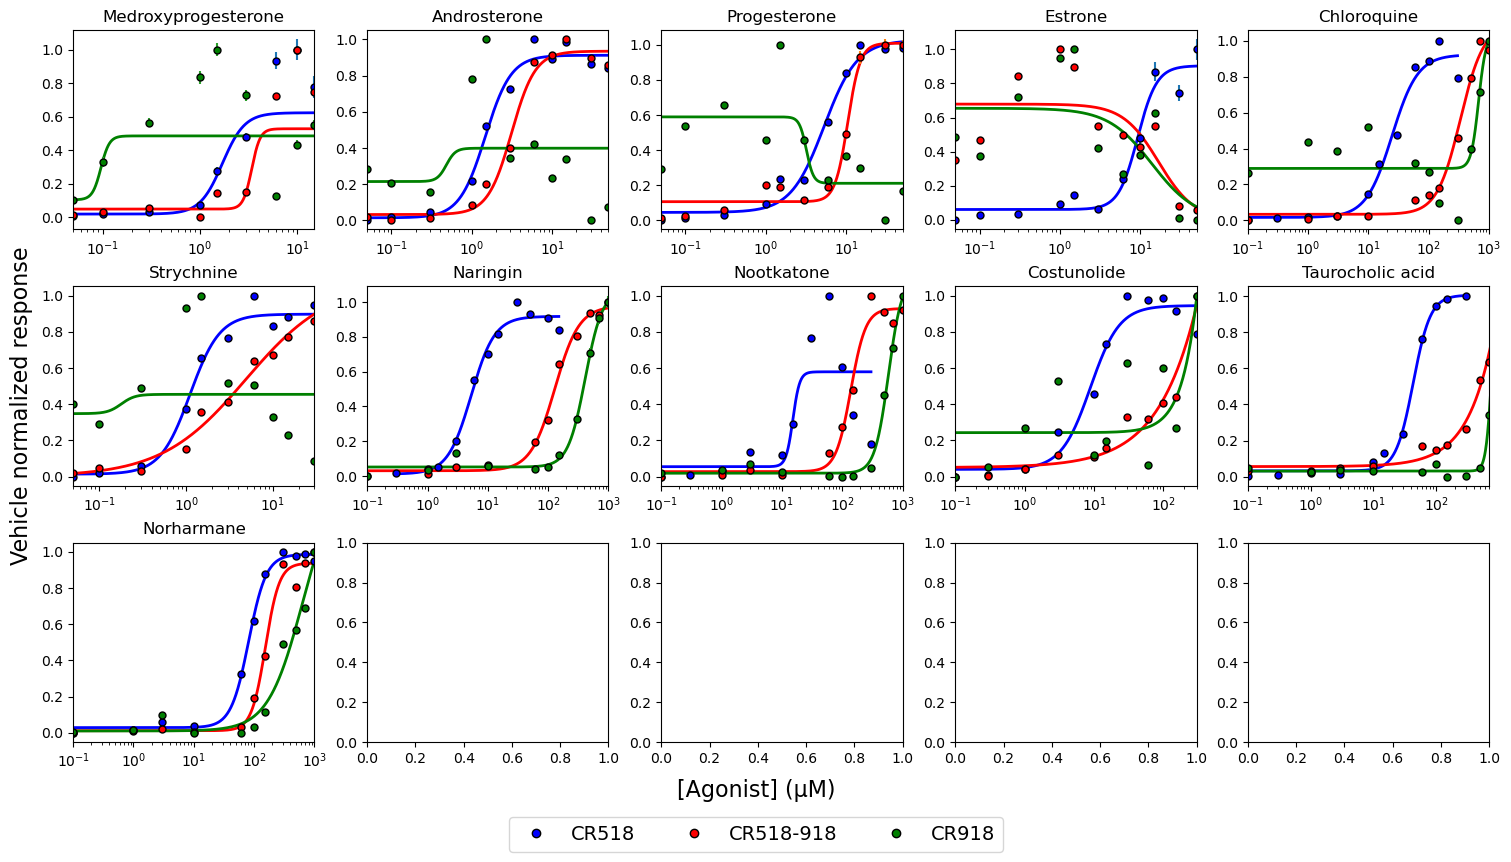

In [18]:
# ---------- plotting grid ----------
nLig = len(ligandList)
nrows, ncols = 3, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8), constrained_layout=True)
axes = axes.ravel()

EC50 = [dict(CR518=np.nan, CR518_918=np.nan, CR918=np.nan, ligands=ligandList[i]) for i in range(nLig)]

for i, lig in enumerate(ligandList):
    ax = axes[i]

    # Means and SEMs (over columns)
    mu_518     = Normalize(np.nanmean(CR518_all[i], axis=1))
    mu_518_918 = Normalize(np.nanmean(CR518_918_all[i], axis=1))
    mu_918     = Normalize(np.nanmean(CR918_all[i], axis=1))
    mu_gc      = np.nanmean(GCaMP_all[i], axis=1)

    se_518     = sem(Normalize(CR518_all[i]), axis=1)
    se_518_918 = sem(Normalize(CR518_918_all[i]), axis=1)
    se_918     = sem(Normalize(CR918_all[i]), axis=1)
    se_gc      = sem(GCaMP_all[i], axis=1)

    # Doses (Var3)
    dose_518     = df_518.iloc[idx_518[i], 2].to_numpy(dtype=float)
    dose_518_918 = df_518_918.iloc[idx_518_918[i], 2].to_numpy(dtype=float)
    dose_918     = df_918.iloc[idx_918[i], 2].to_numpy(dtype=float)

    # --- CR518 fit/plot ---
    k = -1#maxDose_CR518[i]

    hill, ec50, dmin, dmax, coeffs, _, _, model = dose_response_fit(dose_518[:k], mu_518[:k])
    EC50[i]["CR518"] = float(np.real(ec50))
    xs = np.logspace(np.log10(dmin), np.log10(dmax), 1000)
    ax.semilogx(xs, model(xs), lw=2,color='b')
    ax.errorbar(dose_518[:k], mu_518[:k], yerr=se_518[:k], fmt='o', ms=5, mfc='b', mec='k', ls='none')

    # --- CR518-918 fit/plot ---
    k = -1#maxDose_CR518_918[i]
    try:
        hill, ec50, dmin, dmax, coeffs, _, _, model = dose_response_fit(dose_518_918[:k], mu_518_918[:k])
        EC50[i]["CR518_918"] = float(np.real(ec50))
        xs = np.logspace(np.log10(dmin), np.log10(dmax), 1000)
        ax.semilogx(xs, model(xs), lw=2,c='r')
    except Exception:
        pass
    ax.errorbar(dose_518_918[:k], mu_518_918[:k], yerr=se_518_918[:k], fmt='o', ms=5, mfc='r', mec='k', ls='none')

    # --- CR918 fit/plot ---
    k = -1#maxDose_CR918[i]
    try:
        hill, ec50, dmin, dmax, coeffs, _, _, model = dose_response_fit(dose_918[:k], mu_918[:k])
        EC50[i]["CR918"] = float(np.real(ec50))
        xs = np.logspace(np.log10(dmin), np.log10(dmax), 1000)
        ax.semilogx(xs, model(xs), lw=2,color='g')
    except Exception:
        pass
    ax.errorbar(dose_918[:k], mu_918[:k], yerr=se_918[:k], fmt='o', ms=5, mfc='g', mec='k', ls='none')

    # Axes limits and cosmetics
    maxDose_all = np.nanmax([dose_518[maxDose_CR518[i]-1],
                                dose_518_918[maxDose_CR518_918[i]-1],
                                dose_918[maxDose_CR918[i]-1]])
    minDose_all = np.nanmin([dose_518[0], dose_518_918[0], dose_918[0]])
    yMax_margin = 5 if np.isnan(np.nanmax(se_518)) else np.nanmax(se_518)
    yMax = np.round(np.nanmax([np.nanmax(mu_518[:maxDose_CR518[i]]),
                                np.nanmax(mu_518_918[:maxDose_CR518_918[i]]),
                                np.nanmax(mu_918[:maxDose_CR918[i]])])) + yMax_margin


    ax.set_xscale("log")
    ax.set_xlim(minDose_all, maxDose_all)
    #ax.set_ylim(0, yMax)
    ax.set_title(lig, fontsize=12)
    ax.tick_params(labelsize=10)
    #ax.box(False)

# shared labels
fig.supxlabel("[Agonist] (µM)", fontsize=16)
fig.supylabel("Vehicle normalized response", fontsize=16)

# Legend (dummy handles)
h1 = axes[0].plot([], [], 'o', mfc='b', mec='k', label='CR518')[0]
h2 = axes[0].plot([], [], 'o', mfc='r', mec='k', label='CR518-918')[0]
h3 = axes[0].plot([], [], 'o', mfc='g', mec='k', label='CR918')[0]
lgd = fig.legend(handles=[h1, h2, h3], loc="lower center", ncol=3, fontsize=14, bbox_to_anchor=(0.5, -.07))


plt.show()


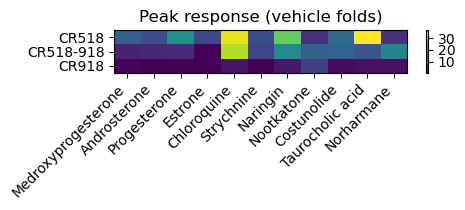

In [26]:

    # --------------------------- MAX AMPLITUDE HEATMAP ---------------------------
    receptors = ["CR518", "CR518-918", "CR918"]
    stackMeans = np.zeros((nLig, 3))
    stackSEMs  = np.zeros((nLig, 3))

    for j in range(nLig):
        stackMeans[j, 0] = np.nanmean(CR518_all[j][maxDose_CR518[j]-1, :])
        stackMeans[j, 1] = np.nanmean(CR518_918_all[j][maxDose_CR518_918[j]-1, :])
        # NOTE: MATLAB snippet used GCaMP for col 3; here we use CR918 (likely intended)
        stackMeans[j, 2] = np.nanmean(CR918_all[j][maxDose_CR918[j]-1, :])

        stackSEMs[j, 0] = sem(CR518_all[j][maxDose_CR518[j]-1, :], axis=0)
        stackSEMs[j, 1] = sem(CR518_918_all[j][maxDose_CR518_918[j]-1, :], axis=0)
        stackSEMs[j, 2] = sem(CR918_all[j][maxDose_CR918[j]-1, :], axis=0)

    fig2, ax2 = plt.subplots(figsize=(5, 2.2))
    im = ax2.imshow(stackMeans.T, aspect="auto", interpolation="nearest")
    ax2.set_xticks(np.arange(nLig), labels=ligandList, rotation=45, ha="right")
    ax2.set_yticks(np.arange(3), labels=receptors)
    ax2.set_title("Peak response (vehicle folds)")
    fig2.colorbar(im, ax=ax2)
    fig2.tight_layout()


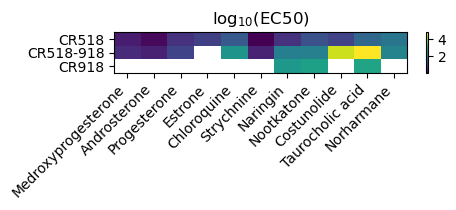

In [27]:
    # --------------------------- EC50 HEATMAP ---------------------------
    EC50_mat = np.full((nLig, 3), np.nan)
    for j in range(nLig):
        if np.isfinite(EC50[j]["CR518"]):      EC50_mat[j, 0] = EC50[j]["CR518"]
        if np.isfinite(EC50[j]["CR518_918"]):  EC50_mat[j, 1] = EC50[j]["CR518_918"]
        if np.isfinite(EC50[j]["CR918"]):      EC50_mat[j, 2] = EC50[j]["CR918"]

    log_ec50 = np.log10(EC50_mat)
    fig3, ax3 = plt.subplots(figsize=(5, 2.2))
    im2 = ax3.imshow(log_ec50.T, aspect="auto", interpolation="nearest")
    ax3.set_xticks(np.arange(nLig), labels=ligandList, rotation=45, ha="right")
    ax3.set_yticks(np.arange(3), labels=receptors)
    ax3.set_title(r"log$_{10}$(EC50)")
    fig3.colorbar(im2, ax=ax3)
    fig3.tight_layout()